In [1]:
# For local development enable python modules live reloading
%load_ext autoreload
%autoreload 2

# Generating gaits

The next step in developing the robot kinematics is to generate various gaits. First, lets familiarize ourselves with the concept of gaits. Gait is a coordinated sequence of movements of the robot legs and body to achieve smooth locomotion.

The gait cycle of a hexapod robot refers to the sequential movement of its six legs to achieve locomotion. It consists of two main phases for each leg:

 1. Stance Phase – The leg is in contact with the ground, providing support and propulsion as it moves backward relative to the body.
 2. Swing Phase – The leg lifts off the ground, moves forward, and prepares for the next stance phase.

To get an idea of the variance and complexity between gaits, Fig 1. shows four typical gaits. The six legs, right and left hind, middle and front, indicated as RH, RM, RF, LH, LM, and LF, at any one time are either on the ground pushing forward (supporting) shown in white, or in the air moving up to their next position (recovering) shown in black. [borrowed from hexapodrobot.weebly.com](https://hexapodrobot.weebly.com/the-legs.html)

<div>
<img src="hexapod_gaits.png" width="600"/>
</div>

Fig 1. Four typical hexapodal gaits, depicting each of the six legs as either supporting (white) or recovering (black). Image source: (Chen et al. 2012)

The two most common gaits for hexapods are the tripod gait and the ripple gait. The tripod gait is a simple gait where the robot legs move in two groups of three, lifting one group of three legs at a time. While the ripple gait is a more complex gait where the legs move in a wave-like motion, lifting one leg at a time.

## Tripod gait

The tripod gait is a simple gait where the robot legs move in two groups of three:
 - group A: left-front, right-middle, and left-back
 - group B: right-front, left-middle, and right-back.

while one group is in stance phase, the other group is in swing phase and cycle repeats.

Lets build the simplest tripod gait generator, it will generate offsets for each leg at a specific phase (0.0 to 1.0).

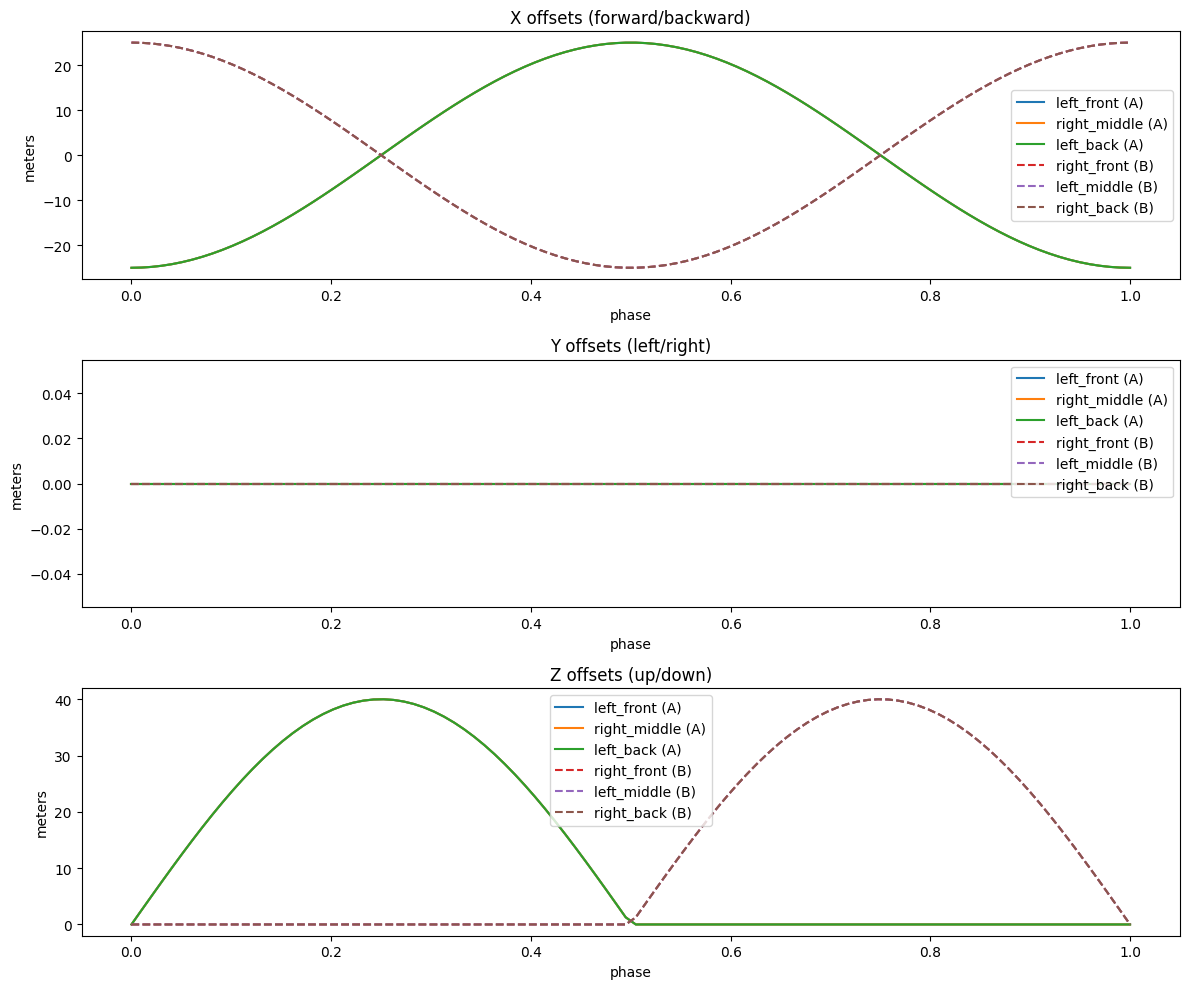

In [2]:
%matplotlib inline

import numpy as np
from gait_generators import GaitGenerator
from point import Point3D


class TripodGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Tripod gait generator for hexapod robot.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters

        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg groups for tripod gait
        self.tripod_a = ['left_front', 'right_middle', 'left_back']
        self.tripod_b = ['right_front', 'left_middle', 'right_back']

    def get_offsets_at_phase(self, phase):
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        # Generate offsets for each leg group
        offsets = {}

        # Tripod A legs
        a_offset = self._calculate_leg_offset(phase)
        for leg in self.tripod_a:
            offsets[leg] = a_offset

        # Tripod B legs (half cycle offset)
        b_offset = self._calculate_leg_offset(phase + 0.5)
        for leg in self.tripod_b:
            offsets[leg] = b_offset

        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase):
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Tripod B legs (half cycle offset)
        if leg in self.tripod_b:
            phase += 0.5

        return self._calculate_leg_offset(phase)

    def _calculate_leg_offset(self, phase):
        """Calculate offset for a single leg at phase."""
        # Ensure phase is between 0 and 1
        phase = phase % 1.0

        # Convert phase to angle (0 to 2π)
        t = phase * 2 * np.pi

        # X movement: forward during swing phase, backward during stance phase
        x_offset = -self.step_length / 2 * np.cos(t)

        # Z movement: up during swing phase, down during stance phase
        z_offset = 0
        if np.sin(t) > 0:  # Only lift during swing phase
            z_offset = self.step_height * np.sin(t)

        # Y offset is always zero for straight walking
        y_offset = 0

        return Point3D([x_offset, y_offset, z_offset])


# Example usage
generator = TripodGaitGenerator()

# Visualize the continuous gait
generator.visualize_continuous(steps=100)


This tripod gait generator:

 1. Creates sequences for all 6 legs divided into two tripod groups
 2. Generates coordinated movement patterns where:
    - Tripod A (leftFront, rightMiddle, leftBack) moves in the first half of the cycle
    - Tripod B (rightFront, leftMiddle, rightBack) moves in the second half
    - When one tripod is lifting and moving forward, the other is on the ground providing support
 3. Provides visualization to help understand the gait pattern
 4. Allows you to extract the pose at any step in the sequence
 
The implementation is based on your existing code structure but simplified for clarity. You can adjust parameters like hipSwing, liftSwing, and stepCount to modify the gait characteristics.



In [3]:
from matplotlib.animation import FuncAnimation
from models import HexapodModel
from plotting import plot_hexapod, update_hexapod_plot, animate_plot_template


def animate_hexapod_gait(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=7.0,
    view_azim=-112,
):
    def animate_impl():
        leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

        def set_pose(step):
            phase = step / total_steps
            for leg, leg_tip in zip(hexapod.legs, leg_tips):
                offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase)
                leg.move_to(leg_tip + offsets)

        fig, ax, plot_data = plot_hexapod(hexapod)
        ax.view_init(elev=view_elev, azim=view_azim)

        def animate(frame):
            set_pose(frame)
            update_hexapod_plot(hexapod, plot_data)

        return FuncAnimation(fig, animate, frames=total_steps, interval=interval)

    return animate_plot_template(animate_impl, interactive=interactive, skip=skip)


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
generator = TripodGaitGenerator(step_length=120)

%matplotlib widget
anim = animate_hexapod_gait(hexapod, generator, interactive=False, skip=False)


Below is an attempt to generate gaits with more parametrization, however it is not very successful. Code was generated by AI that doesn't understand the problem.


ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

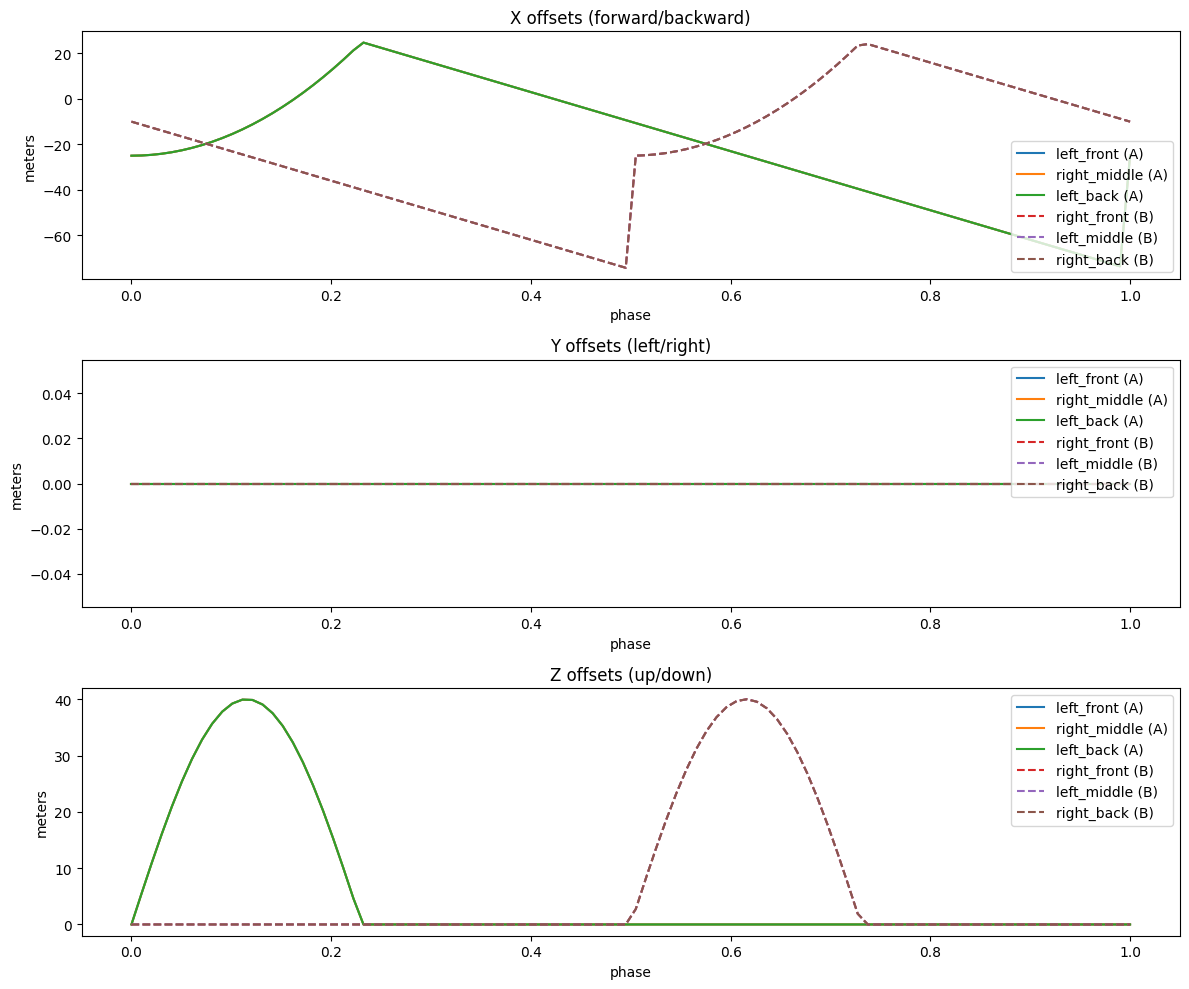

In [4]:
%matplotlib inline


class AdvancedTripodGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
        swing_lateral_distance=0,  # Lateral movement during swing phase
        stance_lateral_distance=0,  # Lateral movement during stance phase
        leg_lift_time=0.3,  # Portion of cycle spent lifting (0-1)
        leg_swing_time=0.5,  # Portion of cycle spent swinging (0-1)
        leg_stance_time=0.5,  # Portion of cycle spent in stance (0-1)
    ):
        """
        Tripod gait generator for hexapod robot.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters
            swing_lateral_distance: Maximum lateral movement during swing phase
            stance_lateral_distance: Maximum lateral movement during stance phase
            leg_lift_time: Portion of cycle spent lifting (0-1)
            leg_swing_time: Portion of cycle spent swinging (0-1)
            leg_stance_time: Portion of cycle spent in stance (0-1)

        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height
        self.swing_lateral_factor = np.radians(swing_lateral_distance)
        self.stance_lateral_factor = np.radians(stance_lateral_distance)

        # Normalize timing parameters
        total_time = leg_lift_time + leg_swing_time + leg_stance_time
        self.leg_lift_time = leg_lift_time / total_time
        self.leg_swing_time = leg_swing_time / total_time
        self.leg_stance_time = leg_stance_time / total_time

        # Calculate phase transitions
        self.lift_start = 0.0
        self.lift_end = self.leg_lift_time
        self.stance_start = self.lift_end
        self.stance_end = self.stance_start + self.leg_stance_time

        # Define leg groups for tripod gait
        self.tripod_a = ['left_front', 'right_middle', 'left_back']
        self.tripod_b = ['right_front', 'left_middle', 'right_back']

    def get_offsets_at_phase(self, phase):
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        # Generate offsets for each leg group
        offsets = {}

        # Tripod A legs
        for leg in self.tripod_a:
            offsets[leg] = self._calculate_leg_offset(phase)

        # Tripod B legs (half cycle offset)
        for leg in self.tripod_b:
            offsets[leg] = self._calculate_leg_offset(phase + 0.5)

        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase):
        """
        Get offsets for a specific leg at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            leg: Leg identifier string
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Tripod B legs (half cycle offset)
        if leg in self.tripod_b:
            phase += 0.5

        return self._calculate_leg_offset(phase)

    def _calculate_leg_offset(self, phase):
        """
        Calculate offset for a single leg at the given phase.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Point3D object with x, y, z offsets

        """
        # Ensure phase is between 0 and 1
        phase = phase % 1.0

        x_offset = 0
        y_offset = 0
        z_offset = 0

        # Lift phase - leg moves up and forward
        if phase < self.lift_end:
            # Normalize phase within lift segment
            lift_phase = phase / self.lift_end

            # Forward movement during lift (accelerating)
            x_offset = -self.step_length / 2 + self.step_length * lift_phase * lift_phase

            # Height follows a sine curve during lift
            z_offset = self.step_height * np.sin(lift_phase * np.pi)

            # Apply lateral movement during swing
            y_offset = self.step_length / 4 * np.sin(self.swing_lateral_factor * lift_phase)

        # Stance phase - leg is on ground, moving backward
        else:
            # Normalize phase within stance segment
            stance_phase = (phase - self.lift_end) / self.leg_stance_time

            # Backward movement during stance (constant speed)
            x_offset = self.step_length / 2 - self.step_length * stance_phase

            # Apply lateral movement during stance
            y_offset = (
                self.step_length / 4 * np.sin(self.stance_lateral_factor * (1 - stance_phase))
            )

            # No vertical movement during stance
            z_offset = 0

        return Point3D([x_offset, y_offset, z_offset])


# Example usage
gaits_gen = AdvancedTripodGaitGenerator()

# Visualize the continuous gait
gaits_gen.visualize_continuous()


In [5]:
hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
gaits_gen = AdvancedTripodGaitGenerator(
    stance_lateral_distance=0,
    swing_lateral_distance=0,
)


%matplotlib widget
anim = animate_hexapod_gait(hexapod, generator, interactive=False, skip=False)
anim = animate_hexapod_gait(hexapod, gaits_gen, interactive=False, skip=False)
